# Understanding Pose Keypoint Normalization

Pose estimation is a fundamental task in computer vision and motion analysis, where we detect and track key anatomical points (keypoints) of a human body. However, raw pose data often comes with various challenges:

- Different body sizes and proportions
- Varying positions in space
- Different viewpoints and rotations


This tutorial explores how to normalize pose keypoints to address these challenges.

In [1]:
from glob import glob
import os
import pandas as pd
import numpy as np

## Reading Data

In [2]:
body_files = glob("P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/Kinematics_Lecture_Series/mediapipe/mediapipe_csvs/**/*body.csv", recursive=True)

In [3]:
body_files

['P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/Kinematics_Lecture_Series/mediapipe/mediapipe_csvs\\Cheeseburger_short\\Cheeseburger_short_body.csv',
 'P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/Kinematics_Lecture_Series/mediapipe/mediapipe_csvs\\Life-Cycles_short\\Life-Cycles_short_body.csv',
 'P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/Kinematics_Lecture_Series/mediapipe/mediapipe_csvs\\Missing-Pieces_short\\Missing-Pieces_short_body.csv',
 'P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/Kinematics_Lecture_Series/mediapipe/mediapipe_csvs\\Roar_short\\Roar_short_body.csv',
 'P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/Kinematics_Lecture_Series/mediapipe/mediapipe_csvs\\Spencer-No-Tunick_short\\Spencer-No-Tunick_short_body.csv']

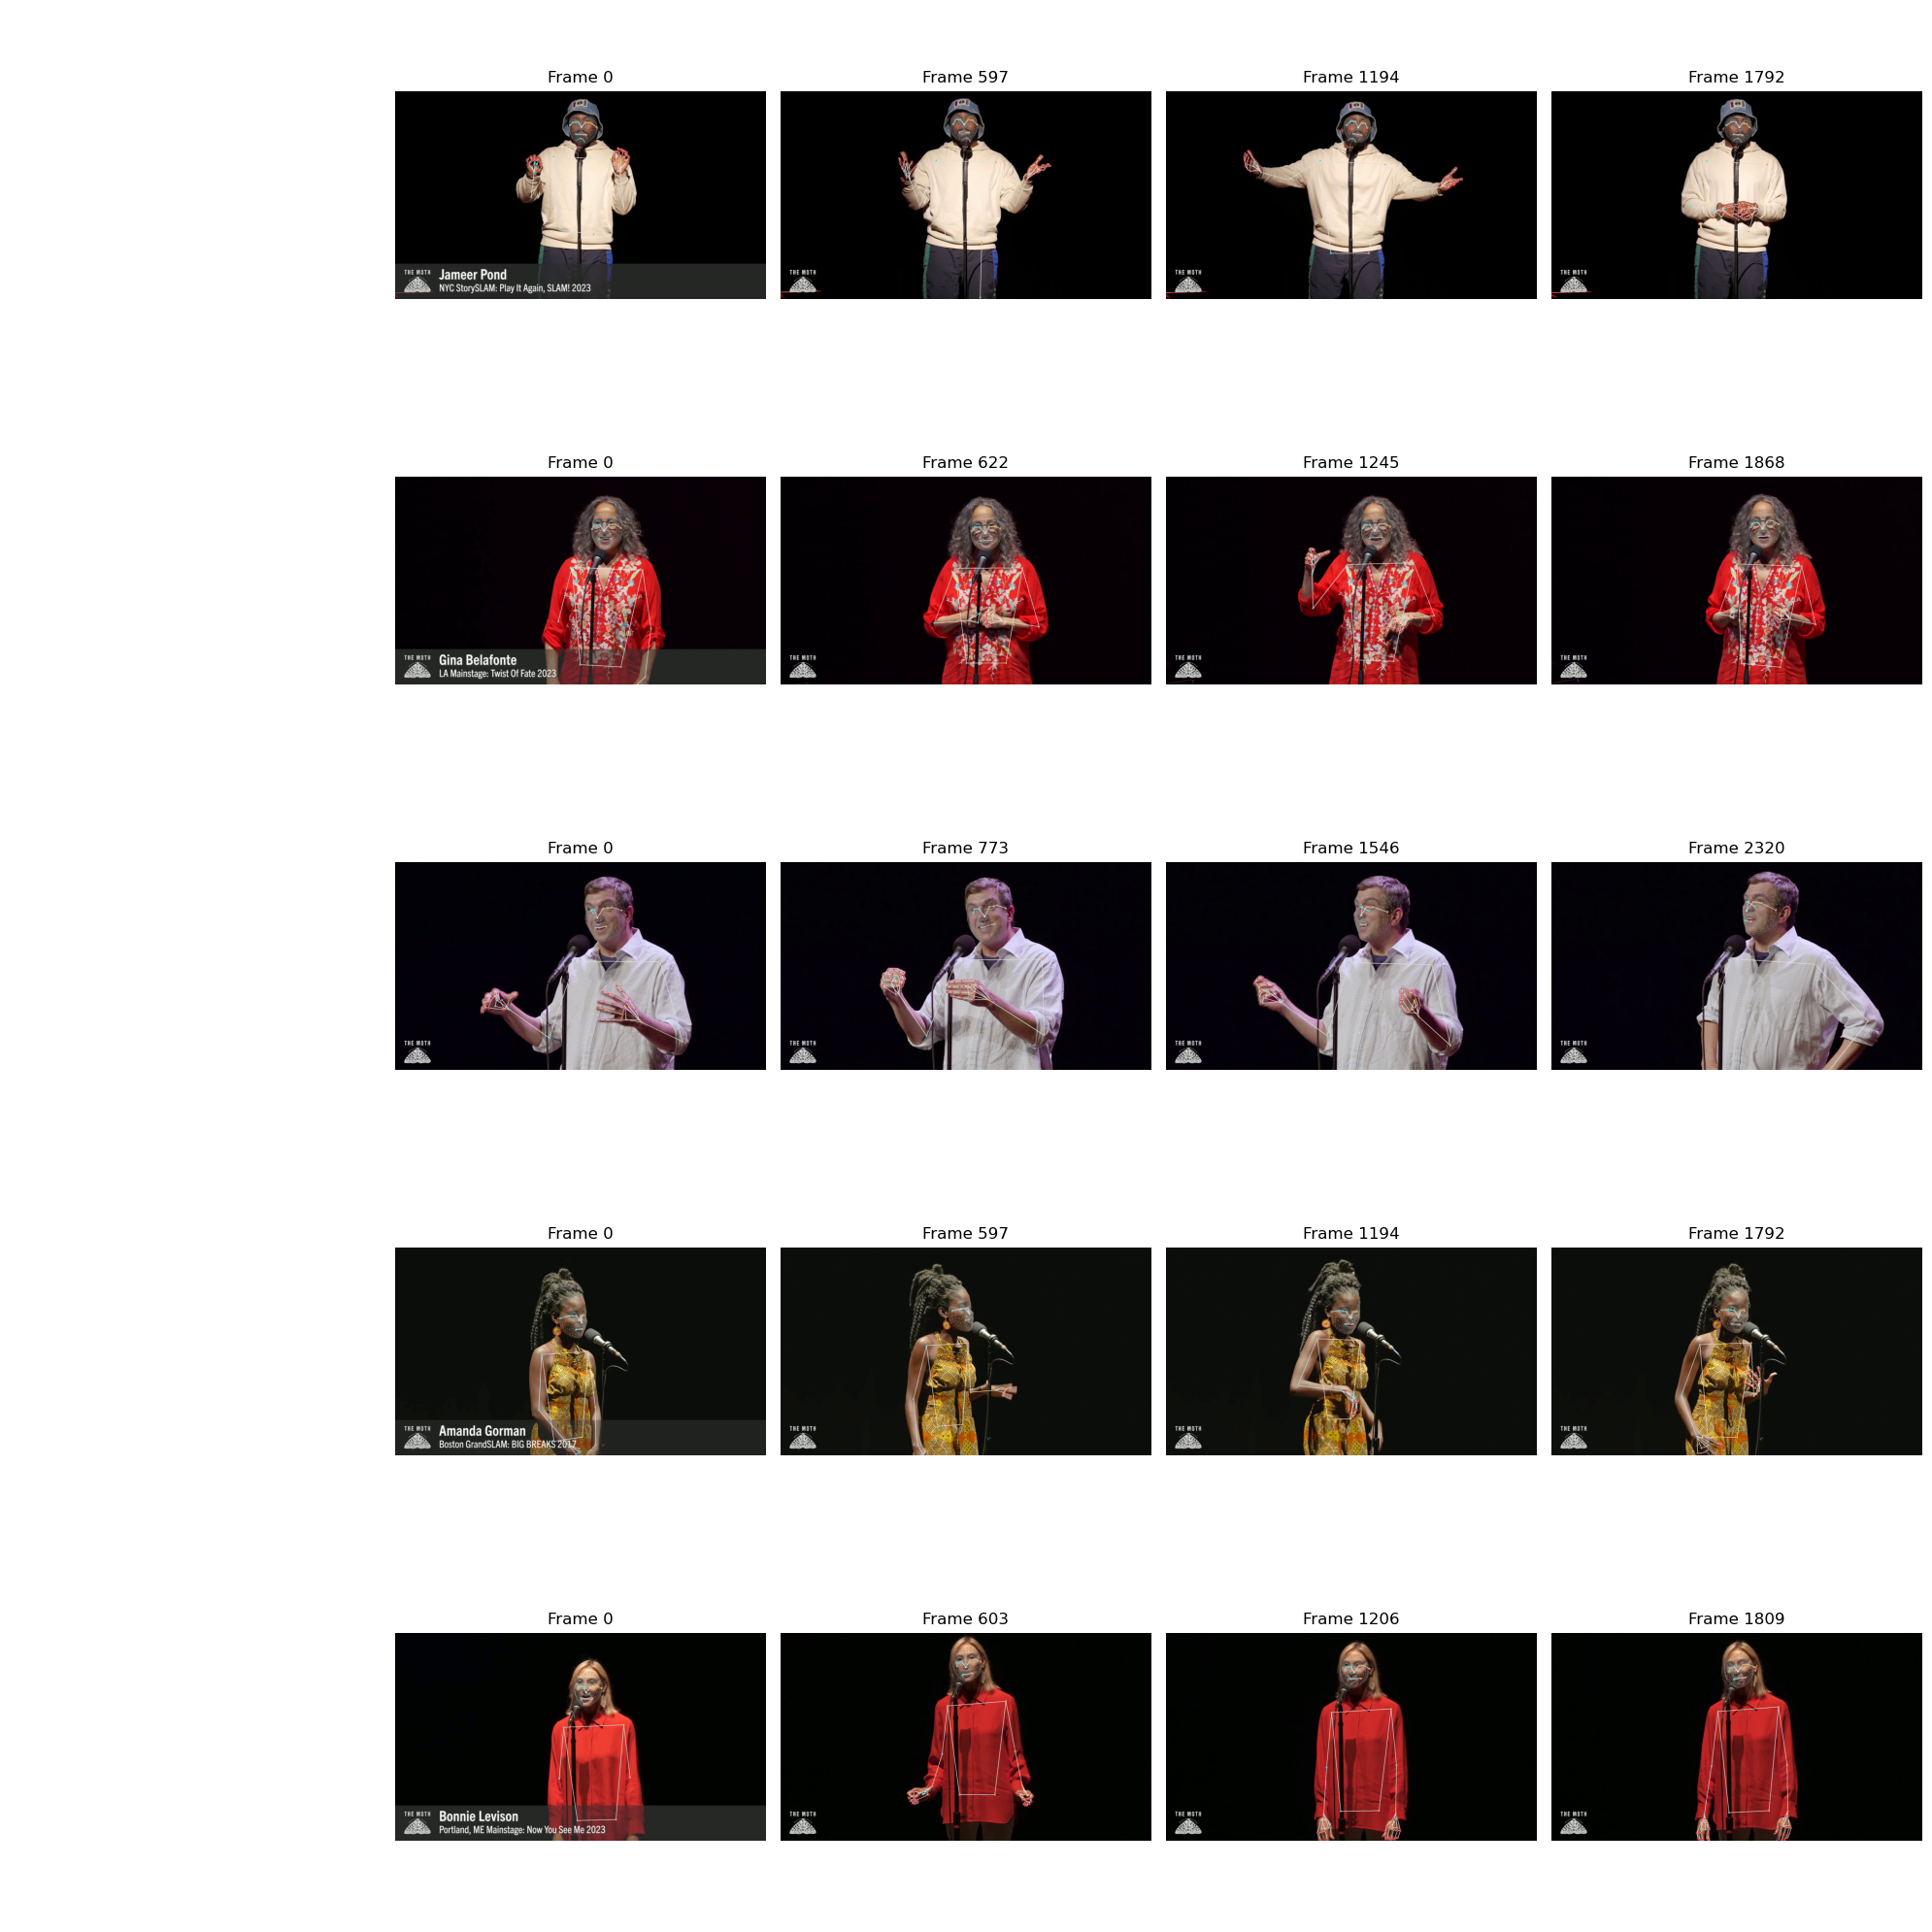

In [4]:
import cv2
from IPython.display import Video, display, HTML
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

def display_video_samples(video_folder, num_frames=4):
    """
    Display sample frames from each video to show diversity in poses.
    
    Args:
        video_folder (str): Path to folder containing MP4 files
        num_frames (int): Number of frames to sample from each video
    """
    video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    
    # Create a grid of subplots
    fig = plt.figure(figsize=(20, 4*len(video_files)))
    gs = GridSpec(len(video_files), num_frames + 1)
    
    for vid_idx, video_file in enumerate(video_files):
        video_path = os.path.join(video_folder, video_file)
        cap = cv2.VideoCapture(video_path)
        
        # Get video properties
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
        
        # Add video name
        # fig.add_subplot(gs[vid_idx, 0])
        # plt.text(0.5, 0.5, f"Video {vid_idx + 1}", fontsize=12)
        plt.axis('off')
        
        # Display frames
        for frame_idx, frame_num in enumerate(frame_indices, 1):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if ret:
                ax = fig.add_subplot(gs[vid_idx, frame_idx])
                ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                ax.axis('off')
                ax.set_title(f'Frame {frame_num}')
        
        cap.release()
    
    plt.tight_layout()
    plt.show()

# Display sample frames from all videos
display_video_samples('P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/Kinematics_Lecture_Series/mediapipe/mediapipe_MP4s/')

## Types of Keypoint Normalization

### Size normalization 

Size normalisation adjusts all keypoints to match a target height, making poses comparable regardless of the subject's actual height.


In [8]:
def normalize_size(df, target_height):
    normalized_df = df.copy()


    keypoint_names = [col for col in list(normalized_df.columns) if not col.startswith('visibility') and col!='time']

     # Process each row (frame)
    for idx, row in df.iterrows():
        # Get shoulder and hip coordinates
        left_shoulder = np.array([row[f'X_LEFT_SHOULDER'], row[f'Y_LEFT_SHOULDER'], row[f'Z_LEFT_SHOULDER']])
        right_shoulder = np.array([row[f'X_RIGHT_SHOULDER'], row[f'Y_RIGHT_SHOULDER'], row[f'Z_RIGHT_SHOULDER']])
        left_hip = np.array([row[f'X_LEFT_HIP'], row[f'Y_LEFT_HIP'], row[f'Z_LEFT_HIP']])
        right_hip = np.array([row[f'X_RIGHT_HIP'], row[f'Y_RIGHT_HIP'], row[f'Z_RIGHT_HIP']])
        
        # Calculate midpoints
        shoulder_midpoint = (left_shoulder + right_shoulder) / 2
        hip_midpoint = (left_hip + right_hip) / 2
        
        # Calculate current height (torso height)
        current_height = np.linalg.norm(shoulder_midpoint - hip_midpoint)
        
        if current_height > 0:
            scale_factor = target_height / current_height
        else:
            print('Warning: Torso Length < 0! Skipping frame', idx) 
            continue
        
        
        # Apply scaling to all keypoints
        for keypoint in keypoint_names:
            normalized_df.at[idx, keypoint] = row[keypoint] * scale_factor
    return normalized_df

In [7]:
# def normalize_size(df, target_shoulder_distance=1.0):
#     """
#     Normalize skeleton size based on shoulder distance and position.
    
#     Args:
#         df: DataFrame with skeleton coordinates
#         target_shoulder_distance: Target distance between shoulders after normalization
        
#     Returns:
#         Normalized DataFrame
#     """
#     normalized_df = df.copy()
#     valid_frames = []
#     shoulder_distances = []
    
#     # Calculate shoulder distances for all frames
#     for idx, row in df.iterrows():
#         # Get shoulder coordinates
#         left_shoulder = np.array([row['X_LEFT_SHOULDER'], row['Y_LEFT_SHOULDER'], row['Z_LEFT_SHOULDER']])
#         right_shoulder = np.array([row['X_RIGHT_SHOULDER'], row['Y_RIGHT_SHOULDER'], row['Z_RIGHT_SHOULDER']])
        
#         # Calculate distance between shoulders
#         shoulder_distance = np.linalg.norm(left_shoulder - right_shoulder)
        
#         # Store valid frames (shoulders detected)
#         MIN_VALID_SHOULDER_LEN = 1e-2
#         if shoulder_distance > MIN_VALID_SHOULDER_LEN:
#             valid_frames.append(idx)
#             shoulder_distances.append(shoulder_distance)
    
#     # Calculate mean shoulder distance from valid frames
#     if len(shoulder_distances) > 0:
#         mean_shoulder_distance = np.mean(shoulder_distances)
#     else:
#         # Fallback if no valid frames
#         mean_shoulder_distance = 1.0
#         print("Warning: No valid frames with detected shoulders found.")
    
#     # Calculate midpoint between shoulders for each frame
#     midpoints = []
#     for idx in valid_frames:
#         row = df.loc[idx]
#         left_shoulder = np.array([row['X_LEFT_SHOULDER'], row['Y_LEFT_SHOULDER'], row['Z_LEFT_SHOULDER']])
#         right_shoulder = np.array([row['X_RIGHT_SHOULDER'], row['Y_RIGHT_SHOULDER'], row['Z_RIGHT_SHOULDER']])
#         midpoint = (left_shoulder + right_shoulder) / 2
#         midpoints.append(midpoint)
    
#     # Calculate average midpoint across all valid frames
#     if midpoints:
#         avg_midpoint = np.mean(midpoints, axis=0)
#     else:
#         avg_midpoint = np.zeros(3)
    
#     # Process each frame in the dataframe
#     for idx, row in df.iterrows():
#         # Get keypoint columns
#         keypoint_columns = [col for col in df.columns if col.startswith(('X_', 'Y_', 'Z_'))]
        
#         # Calculate normalization scale factor based on mean shoulder distance
#         scale_factor = target_shoulder_distance / mean_shoulder_distance if mean_shoulder_distance > 0 else 1.0
        
#         # Get unique keypoint names
#         keypoint_names = sorted(set(['_'.join(col.split('_')[1:]) for col in keypoint_columns if col.startswith('X_')]))
        
#         # Apply normalization to all keypoints
#         for joint_name in keypoint_names:
#             # Extract the 3D point
#             point = np.array([
#                 row[f'X_{joint_name}'],
#                 row[f'Y_{joint_name}'],
#                 row[f'Z_{joint_name}']
#             ])
            
#             # Center using average midpoint and scale using mean shoulder distance
#             normalized_point = (point - avg_midpoint) * scale_factor
            
#             # Store normalized coordinates
#             normalized_df.at[idx, f'X_{joint_name}'] = normalized_point[0]
#             normalized_df.at[idx, f'Y_{joint_name}'] = normalized_point[1]
#             normalized_df.at[idx, f'Z_{joint_name}'] = normalized_point[2]
    
#     return normalized_df

In [8]:
for file in body_files:
    
    df = pd.read_csv(file)
    normalized_df = normalize_size(df, 1)


In [9]:
normalized_df

,time,X_NOSE,Y_NOSE,Z_NOSE,visibility_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,visibility_LEFT_EYE_INNER,X_LEFT_EYE,...,Z_RIGHT_HEEL,visibility_RIGHT_HEEL,X_LEFT_FOOT_INDEX,Y_LEFT_FOOT_INDEX,Z_LEFT_FOOT_INDEX,visibility_LEFT_FOOT_INDEX,X_RIGHT_FOOT_INDEX,Y_RIGHT_FOOT_INDEX,Z_RIGHT_FOOT_INDEX,visibility_RIGHT_FOOT_INDEX
0,0.000000,-0.073362,-0.411101,-2.283406,0.998972,0.005080,-0.568031,-2.178336,0.998413,0.043279,...,3.480268,0.134039,0.168441,6.447863,1.399060,0.027615,-0.211951,6.465640,2.165216,0.058216
1,33.369128,-0.088765,-0.433284,-2.476400,0.999587,-0.011192,-0.591186,-2.376729,0.999399,0.028757,...,3.638010,0.063683,0.124571,6.601788,1.547370,0.014855,-0.279376,6.604358,2.265981,0.027526
2,66.738257,-0.095230,-0.434058,-2.194556,0.999655,-0.016321,-0.596598,-2.103765,0.999461,0.022627,...,3.979678,0.017374,0.089673,6.382289,0.809317,0.005758,-0.315878,6.332397,2.630558,0.008288
3,100.107385,-0.098231,-0.446399,-2.841580,0.999742,-0.020751,-0.612868,-2.751358,0.999617,0.021528,...,3.361401,0.217237,0.212804,6.539431,1.552282,0.083943,-0.194901,6.569693,2.055404,0.138288
4,133.476513,-0.082912,-0.501647,-2.550304,0.999404,-0.007870,-0.659560,-2.430398,0.999255,0.032758,...,3.812543,0.172357,0.189930,6.711828,1.410260,0.063215,-0.195477,6.741366,2.449450,0.102090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,60231.276581,-0.126616,-0.933423,-2.221037,0.999908,-0.067433,-1.111779,-2.084327,0.999854,-0.022051,...,3.945442,0.076867,0.267634,6.378457,1.790119,0.048046,-0.163760,6.448961,2.537134,0.038918
1806,60264.645709,-0.148825,-0.924203,-2.194725,0.999904,-0.082858,-1.092580,-2.071405,0.999846,-0.035831,...,3.752387,0.082862,0.276645,6.276280,1.674536,0.043883,-0.148427,6.320594,2.388423,0.031769
1807,60298.014837,-0.138171,-0.953059,-2.084525,0.999883,-0.072675,-1.124597,-1.952701,0.999820,-0.029895,...,3.621933,0.085847,0.242041,6.320665,1.679177,0.043949,-0.185810,6.373405,2.249242,0.033610
1808,60331.383966,-0.139584,-0.944896,-2.061085,0.999922,-0.072126,-1.109284,-1.915418,0.999878,-0.027317,...,4.018119,0.058521,0.232583,6.435346,1.666871,0.036063,-0.179856,6.492684,2.608261,0.028916


### Position Normalization

Position normalization centers the skeleton at the origin, making it easier to compare poses regardless of their location in space.

In [7]:
def normalize_position(df, ref_point):
    normalized_df = df.copy()

    keypoint_names = [col for col in list(normalized_df.columns) if not col.startswith('visibility') and col!='time']

    
    
    for idx, row in df.iterrows():

        if ref_point == 'neck':
            ref_x = (row['X_LEFT_SHOULDER'] + row['X_RIGHT_SHOULDER'])/2
            ref_y = (row['Y_LEFT_SHOULDER'] + row['Y_RIGHT_SHOULDER'])/2
            ref_z = (row['Z_LEFT_SHOULDER'] + row['Z_RIGHT_SHOULDER'])/2

        
        for keypoint in keypoint_names:
            normalized_df.at[idx, keypoint] = row[keypoint] - ref_x
            normalized_df.at[idx, keypoint] = row[keypoint] - ref_y
            normalized_df.at[idx, keypoint] = row[keypoint] - ref_z
    return normalized_df

In [8]:
for file in body_files:
    df = pd.read_csv(file)
    df_normalized_position = normalize_position(df, 'neck')
    

### View Normalization

View normalization aligns the skeleton to a standard front-facing view, removing rotational variations.


In [9]:
def normalize_view(df):
    """
    Create a reference coordinate system based on body landmarks that is
    invariant to camera position. 
    
    Parameters:
    df: DataFrame with pose keypoints
    
    Returns:
    transformed_df: DataFrame with normalized keypoints
    transformation_matrices: Dict mapping frame indices to transformation matrices
    """
    transformed_df = df.copy()
    transformation_matrices = {}
    
    # Process each row (frame)
    for idx, row in df.iterrows():
        # Get key points for creating coordinate system
        left_shoulder = np.array([row['X_LEFT_SHOULDER'], row['Y_LEFT_SHOULDER'], row['Z_LEFT_SHOULDER']])
        right_shoulder = np.array([row['X_RIGHT_SHOULDER'], row['Y_RIGHT_SHOULDER'], row['Z_RIGHT_SHOULDER']])
        left_hip = np.array([row['X_LEFT_HIP'], row['Y_LEFT_HIP'], row['Z_LEFT_HIP']])
        right_hip = np.array([row['X_RIGHT_HIP'], row['Y_RIGHT_HIP'], row['Z_RIGHT_HIP']])
        
        # Calculate reference points
        shoulder_center = (left_shoulder + right_shoulder) / 2
        hip_center = (left_hip + right_hip) / 2
        
        # Create orthonormal basis vectors
        # Z-axis: points forward from the body (perpendicular to the shoulder line and up vector)
        y_temp = shoulder_center - hip_center  # Temporary up vector
        shoulder_vector = right_shoulder - left_shoulder
        z_axis = np.cross(shoulder_vector, y_temp)
        # z_axis = np.cross(y_temp, shoulder_vector)
          
        z_axis = z_axis / np.linalg.norm(z_axis)
        
        # Y-axis: points up along the spine
        y_axis = y_temp / np.linalg.norm(y_temp)
        
        # X-axis: points to the person's right
        x_axis = np.cross(y_axis, z_axis)
        x_axis = x_axis / np.linalg.norm(x_axis)
        
        # Create rotation matrix
        rotation_matrix = np.column_stack([x_axis, y_axis, z_axis])
        
        # Create translation vector
        translation = -(rotation_matrix.T @ shoulder_center)
        
        # Create full transformation matrix
        transform = np.eye(4)
        transform[:3, :3] = rotation_matrix.T
        transform[:3, 3] = translation
        
        # Store transformation matrix
        transformation_matrices[idx] = transform
        
        # Gather all keypoints from this frame
        keypoint_columns = [col for col in df.columns if col.startswith(('X_', 'Y_', 'Z_'))]
        keypoint_names = sorted(set(['_'.join(col.split('_')[1:]) for col in keypoint_columns]))
        
        # Apply transformation to all keypoints
        for keypoint in keypoint_names:
            # Extract the 3D point
            point = np.array([
                row[f'X_{keypoint}'],
                row[f'Y_{keypoint}'],
                row[f'Z_{keypoint}']
            ])
            
            # Convert to homogeneous coordinates
            homogeneous_point = np.append(point, 1)
            
            # Apply transformation
            transformed_point = transform @ homogeneous_point
            
            # Store the result back to the DataFrame
            transformed_df.at[idx, f'X_{keypoint}'] = transformed_point[0]
            transformed_df.at[idx, f'Y_{keypoint}'] = transformed_point[1]
            transformed_df.at[idx, f'Z_{keypoint}'] = transformed_point[2]
    
    return transformed_df, transformation_matrices

In [10]:
for file in body_files:
    df = pd.read_csv(file)
    df_normalized_view = normalize_view(df)
    